In [1]:
# 新闻+技术指标+外部影响
# 新闻情绪的提取：BERT
# 傅立叶变换:消除许多噪音（随机漫步) lasso回归(L1)既做变量选择又做参数收缩，而Ridge回归只做参数收缩，并最终包含模型中的所有系数
# Error=bias^2+variance+σ

In [1]:
from utils import *
import time
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)
# def parser(x):
#     return datetime.datetime.strptime(x.str(),'%Y-%m-%d')
df = pd.read_excel('./stock.xlsx')

In [3]:
df['trade_date']  = df['trade_date'].apply(str)
df['trade_date'] =pd.to_datetime(df.trade_date,format="%Y/%m/%d")
df.head(3)

,ts_code,trade_date,name,open,low,high,close,change,pct_change,vol,amount,pe,pb,y
0,801010,2014-04-01,农林牧渔,1668.75,1668.54,1689.12,1689.07,22.13,1.33,34914,291113,41.51,2.77,1
1,801010,2014-04-02,农林牧渔,1688.72,1684.53,1693.41,1692.24,3.17,0.19,36300,289020,41.63,2.79,1
2,801010,2014-04-03,农林牧渔,1693.05,1679.85,1697.73,1685.71,-6.53,-0.39,31403,259464,41.38,2.78,0


In [ ]:
print('There are {} number of days in the dataset.'.format(df.shape[0]))

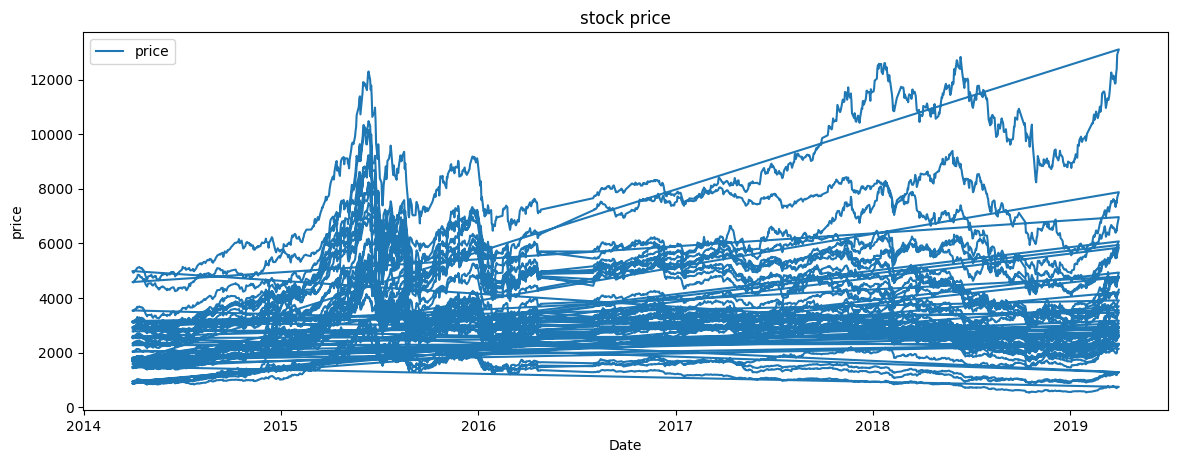

In [4]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df['trade_date'],df['close'], label='price')
plt.xlabel('Date')
plt.ylabel('price')
plt.title('stock price')
plt.legend()
plt.show()

In [4]:
Train, Test = train_test_split(df,test_size=0.2, random_state=0)

In [5]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

In [10]:
df['name'].value_counts()

农林牧渔       1152
交银装备       1152
公用事业       1152
申万300指数    1152
申万制造       1152
通信         1152
家用电器       1152
食品饮料       1152
电气设备       1152
国防军工       1152
建筑装饰       1152
纺织服装       1152
计算机        1152
交通运输       1152
银行         1152
商业贸易       1152
建筑材料       1152
有色金属       1152
轻工制造       1152
综合         1152
申万消费       1152
化工         1152
电子         1152
汽车         1152
采掘         1152
房地产        1152
医药生物       1152
机械设备       1152
申万服务       1152
申万投资       1152
非银金融       1152
传媒         1152
钢铁          952
休闲服务        952
黑色金属        200
餐饮旅游        200
Name: name, dtype: int64

# 技术指标

In [7]:
df1=df.loc[df['name']=='农林牧渔']
df1['1'] = df1['vol'].pct_change()
df1
# training_set = df1['close']
# training_set=pd.DataFrame(training_set)
# sc = MinMaxScaler(feature_range = (0, 1))
# # training_set_scaled = sc.fit_transform(training_set)
# training_set_scaled = np.array(training_set)
# x= []
# y = []
# for i in range(10, 1152):
#     x.append(training_set_scaled[i-10:i, 0])
#     y.append(training_set_scaled[i, 0])
# xtrain, xtest, ytrain, ytest = train_test_split(
#     x, y, test_size=0.2, random_state=0)
# xtrain, xtest, ytrain, ytest = np.array(xtrain),np.array(xtest),np.array(ytrain),np.array(ytest)
# xtrain.shape, xtest.shape, ytrain.shape, ytest.shape
# xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
# xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))
# xtrain.shape

,ts_code,trade_date,name,open,low,high,close,change,pct_change,vol,amount,pe,pb,y,1
0,801010,2014-04-01,农林牧渔,1668.75,1668.54,1689.12,1689.07,22.13,1.33,34914,291113,41.51,2.77,1,NaN
1,801010,2014-04-02,农林牧渔,1688.72,1684.53,1693.41,1692.24,3.17,0.19,36300,289020,41.63,2.79,1,0.039698
2,801010,2014-04-03,农林牧渔,1693.05,1679.85,1697.73,1685.71,-6.53,-0.39,31403,259464,41.38,2.78,0,-0.134904
3,801010,2014-04-04,农林牧渔,1681.92,1680.34,1698.44,1698.25,12.54,0.74,28648,240940,41.76,2.80,1,-0.087730
4,801010,2014-04-08,农林牧渔,1693.24,1692.22,1706.84,1706.84,8.59,0.51,35012,312423,42.00,2.79,1,0.222145
5,801010,2014-04-09,农林牧渔,1708.13,1707.49,1726.01,1725.55,18.71,1.10,43114,378611,41.68,2.81,1,0.231406
6,801010,2014-04-10,农林牧渔,1723.57,1721.18,1730.89,1725.67,0.12,0.01,42089,386253,41.68,2.81,1,-0.023774
7,801010,2014-04-11,农林牧渔,1721.84,1713.55,1724.08,1719.15,-6.52,-0.38,33973,302877,41.38,2.80,0,-0.192829
8,801010,2014-04-14,农林牧渔,1718.35,1717.57,1751.81,1749.88,30.73,1.79,45683,440762,42.11,2.86,1,0.344685
9,801010,2014-04-15,农林牧渔,1747.73,1743.36,1758.92,1748.24,-1.64,-0.09,52524,482483,41.83,2.89,0,0.149749


In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [18]:
regressor = Sequential()
regressor.add(LSTM(units = 30, return_sequences = True, input_shape = (xtrain.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 30, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 30, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 30))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(xtrain, ytrain, epochs = 100, batch_size = 20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
913/913 [==============================] - 5s 6ms/step - loss: 8393867.6796
Epoch 2/100
913/913 [==============================] - 2s 2ms/step - loss: 8363240.6933
Epoch 3/100
913/913 [==============================] - 2s 2ms/step - loss: 8352735.4469
Epoch 4/100
913/913 [==============================] - 2s 2ms/step - loss: 8343621.1051
Epoch 5/100
913/913 [==============================] - 2s 2ms/step - loss: 8334101.1774
Epoch 6/100
913/913 [==============================] - 2s 2ms/step - loss: 8325349.9797
Epoch 7/100
913/913 [==============================] - 2s 2ms/step - loss: 8316611.4754
Epoch 8/100
913/913 [==============================] - 2s 2ms/step - loss: 8308673.1347
Epoch 9/100
913/913 [==============================] - 2s 2ms

In [20]:
predicted_stock_price = regressor.predict(xtest)
np.sqrt(mean_squared_error(predicted_stock_price.astype(int), ytest.astype(int)))

2706.7098922950786

In [12]:
# df1 = pd.DataFrame()
# df1['ma7'] = df.groupby(["ts_code"])['close'].rolling(window=7).mean()
# df1['ma21'] = df.groupby(["ts_code"])['close'].rolling(window=21).mean()
# df2 = pd.merge(df, df1, on=['ts_code'])
def get_technical_indicators(df1):
    # Create 7 and 21 days Moving Average
    df1['ma7'] = df1['close'].rolling(window=7).mean()
    df1['ma21'] = df1['close'].rolling(window=21).mean()
    # Create MACD
    df1['26ema'] = pd.DataFrame.ewm(df1['close'], span=26).mean
    df1['12ema'] = pd.DataFrame.ewm(df1['close'], span=12).mean
    df1['MACD'] = (df1['12ema']-df1['26ema'])
    # Create Bollinger Bands
    df1['20sd'] = pd.stats.moments.rolling_std(df1['close'],20)
    df1['upper_band'] = df1['ma21'] + (df1['20sd']*2)
    df1['lower_band'] = df1['ma21'] - (df1['20sd']*2)
    # Create Exponential moving average
    df1['ema'] = df1['close'].ewm(com=0.5).mean()
    # Create Momentum
    df1['momentum'] = df1['close']-1
    return df1

In [13]:
get_technical_indicators(df1)

TypeError: unsupported operand type(s) for -: 'method' and 'method'

In [21]:
# 傅里叶变换
